# Train network Notebook
Parsa Nasirimehr  
Hossein Abedi. K.

In [2]:
##
# %tensorflow_version 1.x
import datetime
print(f'Start: {datetime.datetime.now()}')
# %cd C:\Users\Worker\Desktop\computer-vision
%pwd
%ls

Start: 2020-07-23 17:52:40.850531
'CV-Project Phase 1.pdf'   Form_A5.pdf         Main5_Dataset.py
 dataset/                  Keras_Alphabet.py   model_no.h5
 Dataset.ipynb             Keras_Intro.ipynb   phaseOne.py
 Dataset.py                Keras_Numbers.py    Test.py
 examples/                 Main4_ARUCO.py      Util_Dataset.py


In [3]:
import warnings
warnings.filterwarnings('ignore')
import keras
import glob
from tqdm import tqdm
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [14]:
# ['filename','letter',code]
list_dataset_items = [
	["no_0_", 0, "۰"],
    ["no_1_", 1, "۱"],
    ["no_2_", 2, "۲"],
    ["no_3_", 3, "۳"],
    ["no_4_", 4, "۴"],
    ["no_5_", 5, "۵"],
    ["no_6_", 6, "۶"],
    ["no_7_", 7, "۷"],
    ["no_8_", 8, "۸"],
    ["no_9_", 9, "۹"],
    ["al_al_", 10, "ا"],
    ["al_be_", 11, "ب"],
    ["al_pe_", 12, "پ"],
    ["al_te_", 13, "ت"],
    ["al_ss_", 14, "ث"],
    ["al_jm_", 15, "ج"],
    ["al_ch_", 16, "چ"],
    ["al_hh_", 17, "ح"],
    ["al_kh_", 18, "خ"],
    ["al_dl_", 19, "د"],
    ["al_zl_", 20, "ذ"],
    ["al_rr_", 21, "ر"],
    ["al_zz_", 22, "ز"],
    ["al_jz_", 23, "ژ"],
    ["al_sn_", 24, "س"],
    ["al_shn_", 25, "ش"],
    ["al_sd_", 26, "ص"],
    ["al_zd_", 27, "ض"],
    ["al_ta_", 28, "ط"],
    ["al_za_", 29, "ظ"],
    ["al_ay_", 30, "ع"],
    ["al_ghy_", 31, "غ"],
    ["al_fe_", 32, "ف"],
    ["al_gh_", 33, "ق"],
    ["al_kf_", 34, "ک"],
    ["al_gf_", 35, "گ"],
    ["al_lm_", 36, "ل"],
    ["al_mm_", 37, "م"],
    ["al_nn_", 38, "ن"],
    ["al_vv_", 39, "و"],
    ["al_he_", 40, "ه"],
    ["al_ye_", 41, "ی"]
]
list_dataset_items = np.array(list_dataset_items)


def get_char_ds(filename):
    """
    return code and character for the given filename
    returns "X" if not found
    """
    for row in list_dataset_items:
        if row[0] in filename:
            return (row[1] , row[2])
    return "X"

def is_digit(code):
    return code < 10

def read_data(data_dir, num_classes, label_offset=0):
    """
    reads data from given directory
    returns list of data and list of labels
    offset is used when training alphabets
    """
    train_dirs = glob.glob(data_dir)
    train_dirs.sort()
    train_dirs = train_dirs[:num_classes]
    data = []
    labels = []
    for train_dir in tqdm(train_dirs):
        imgPaths = glob.glob(train_dir + "/*.jpg")
        imgPaths.sort()
        for imgPath in tqdm(imgPaths):
            code, _ = get_char_ds(imgPath)
            code = int(code)
            image = load_img(imgPath, target_size=(28, 28), grayscale=True)
            image = img_to_array(image) 
            data.append(image)
            labels.append(code+label_offset)
    return  data, labels

## Global program config

In [28]:
#indicated whether training digits or alphabets
working_digits = True
num_classes_no = 10     #number of classes for digits
num_classes_alp = 32    #number of classes for alphabets
model_name_no = "model_no.h5"
model_name_alp = "model_alp.h5"
plot_name_no = "train_plot_no.png"
plot_name_alp = "train_plot_alp.png"
EPOCHS = 40
BS = 32

### Data reading

In [29]:

if working_digits:
    test_data, test_labels = read_data("dataset/test/no*", num_classes_no)
    data, labels = read_data("dataset/processed/no*", num_classes_no)
    num_classes = num_classes_no
    model_name = model_name_no
    plot_name = plot_name_no
else:
    test_data, test_labels = read_data("dataset/test/al*", num_classes_no,label_offset=-10)
    data, labels = read_data("dataset/processed/al*", num_classes_alp,label_offset=-10)
    num_classes = num_classes_alp
    model_name = model_name_alp
    plot_name = plot_name_alp

print(f"Set of labels: {set(labels)}")

#prepare data and labels
data = np.array(data, dtype=np.float) / 255.
labels = np.array(labels)

100%|██████████| 75/75 [00:00<00:00, 1768.09it/s]

100%|██████████| 75/75 [00:00<00:00, 1948.21it/s]

100%|██████████| 75/75 [00:00<00:00, 1663.38it/s]

100%|██████████| 76/76 [00:00<00:00, 1781.74it/s]

100%|██████████| 107/107 [00:00<00:00, 1836.63it/s]

100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Set of labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


### Data Preparation

In [30]:
#seperate into training and validation
from sklearn.model_selection import train_test_split
train_input, valid_input, train_target, valid_target \
    = train_test_split(data, labels, test_size=0.25, random_state=103)

In [31]:
from keras.utils import to_categorical
train_target = to_categorical(train_target, num_classes=num_classes)
valid_target = to_categorical(valid_target, num_classes=num_classes)

In [32]:
#imgae augmentation
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1)

### Models and networks

In [36]:
#model building processes
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.models import Model
def build_model(inputs):
  x = inputs

  x = Conv2D(filters=20, kernel_size=(5, 5), padding="same", activation="relu")(x)
  x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

  x = Conv2D(filters=50, kernel_size=(5, 5), padding="same", activation="relu")(x)
  x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x) 

  x = Flatten()(x)
  x = Dense(500, activation="relu")(x)
  outputs = Dense(num_classes, activation="softmax")(x)

  model = Model(inputs, outputs, name="LeNet")
  model.summary()
  
  return model
print("DONE")


DONE


In [34]:
input = Input((28, 28, 1))
model = build_model(input)

opt = Adam()
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["acc"])

#model checkpoint configuration
checkpoint = ModelCheckpoint(filepath=model_name,
                             monitor="val_acc",
                             verbose=1,
                             save_best_only=True)
#Start training
training_log = model.fit_generator(aug.flow(train_input, train_target, batch_size=BS),
                        steps_per_epoch=len(train_input) // BS,
                        validation_data=[valid_input, valid_target],
                        epochs=EPOCHS,
                        callbacks=[checkpoint])

Model: "LeNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 20)        520       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 50)        25050     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2450)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 500)               122550

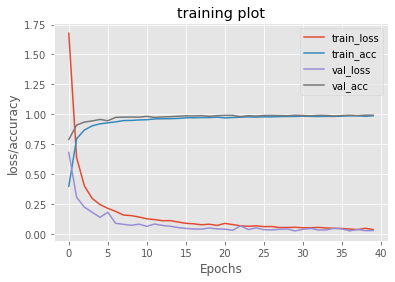

In [37]:
#plot result of training
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(EPOCHS), training_log.history["loss"], label="train_loss")
plt.plot(np.arange(EPOCHS), training_log.history["acc"], label="train_acc")
plt.plot(np.arange(EPOCHS), training_log.history["val_loss"], label="val_loss")
plt.plot(np.arange(EPOCHS), training_log.history["val_acc"], label="val_acc")
plt.xlabel("Epochs")
plt.ylabel("loss/accuracy")
plt.title("training plot")
plt.legend(loc="middle right")
plt.savefig(plot_name)

## Testing model

Model: "LeNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 20)        520       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 50)        25050     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2450)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 500)               122550

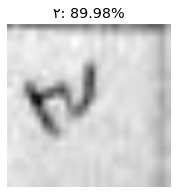

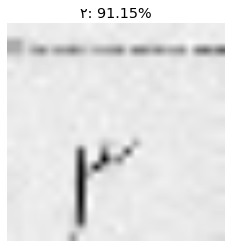

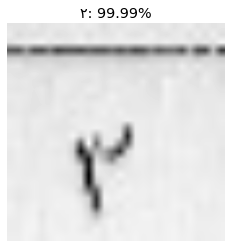

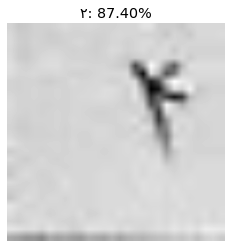

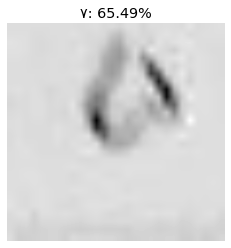

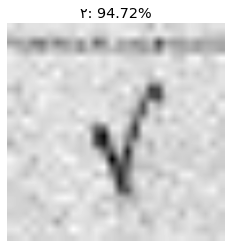

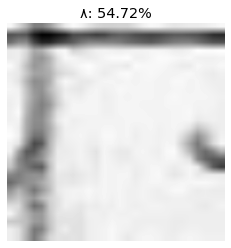

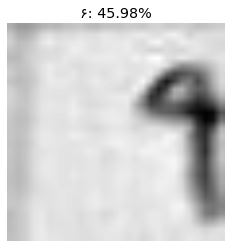

In [39]:
test_result_total = len(test_data)
test_result_correct = 0
test_result_wrong = 0
#compile and prepare model
input = Input((28, 28, 1))
model = build_model(input)
opt = Adam()
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["acc"])
#load model from file
model.load_weights(model_name)

plt.figure(figsize=(3, 3))
for i, test in enumerate(test_data):
    #prepare image for test (normalize to 0-1, and make batch)
    image = img_to_array(test) / 255.
    orig_img = image.copy()
    image = np.expand_dims(image, 0)
    #run prediction
    predictions = model.predict(image)[0]
    true_label = test_labels[i]
    label = np.argmax(predictions)
    if not working_digits:
        #re-offset labels if working with alphabets
        label = label+10
        true_label = true_label+10
    #get predicted label character
    name_label = list_dataset_items[label][2]
    proba = np.max(predictions)
    if label == true_label:
        #go to next test if it was correct prediction
        test_result_correct = test_result_correct+1
        continue
    else:
        test_result_wrong = test_result_wrong+1
    #diplay test image with the wrong label
    output = cv2.resize(orig_img, (400, 400))
    #optimized for showing image in Jupyter notebook
    plt.subplot(1, 1, 1)
    print(f"label {label}, true:{true_label}, {name_label}, {list_dataset_items[true_label][2]}")
    plt.imshow(output, cmap="gray")
    plt.axis("off")
    plt.title("{}: {:.2f}%".format(name_label, proba * 100))
    plt.show()
print("Success rate: {:.2f}%".format(test_result_correct/test_result_total*100))
print("Failure rate: {:.2f}%".format(test_result_wrong/test_result_total*100))